# Problem Statement:
**The Goal is to predict the age of abalone from various physical measurements. 
The goal is to predict the age of the Abalone from the physical measurements. The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict the age. Further information, such as weather patterns and location (hence food availability) may be required to solve the problem [https://archive.ics.uci.edu/dataset/1/abalone]

The dataset used is based on the synethetic dataset **[https://www.kaggle.com/competitions/playground-series-s4e4/data] 

# Dataset Description: 
Sex / nominal / -- / M, F, and I (infant) 
Length / continuous / mm / Longest shell measurement 
Diameter / continuous / mm / perpendicular to length 
Height / continuous / mm / with meat in shell 
Whole weight / continuous / grams / whole abalone 
Shucked weight / continuous / grams / weight of meat 
Viscera weight / continuous / grams / gut weight (after bleeding) 
Shell weight / continuous / grams / after being dried 
Rings / integer / -- / +1.5 gives the age in years


The notebook is divided into following steps:
* Importing the Libraries
* Expolratory Data Analysis
* Data Pre-processing
* Hyperparameter Tunning - LGBM
* Hyperparameter Tunning - XGBoost 
* Hyperparameter Tunning - CatBoost
* Ensemble Weight Tunning
* Ensemble and Final Model
* Final Submission


# Importing all the Libraries

In [1]:
!pip install prettytable 
!pip install ucimlrepo
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np # linear algebra
import pandas as pd 
import math
from prettytable import PrettyTable
from sklearn.preprocessing import FunctionTransformer,OneHotEncoder, StandardScaler,RobustScaler,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost  import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold, train_test_split
import optuna
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 700)
warnings.filterwarnings("ignore")

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 
original_data=pd.merge(X,y, how="inner", left_index=True, right_index=True)
original_data.shape

(4177, 9)

# Expolratory Data Analysis

In [3]:
df_train=pd.read_csv(r'/kaggle/input/playground-series-s4e4/train.csv')
df_test=pd.read_csv(r'/kaggle/input/playground-series-s4e4/test.csv')

In [4]:
print(f"Shape of the Train Data: {df_train.shape}")

df_train.head().style.set_caption("Sample of data in the Train data file"). \
set_properties(**{'border': '1.3px solid blue',
                          'color': 'grey'})

Shape of the Train Data: (90615, 10)


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550000,0.430000,0.150000,0.771500,0.328500,0.146500,0.240000,11
1,1,F,0.630000,0.490000,0.145000,1.130000,0.458000,0.276500,0.320000,11
2,2,I,0.160000,0.110000,0.025000,0.021000,0.005500,0.003000,0.005000,6
3,3,M,0.595000,0.475000,0.150000,0.914500,0.375500,0.205500,0.250000,10
4,4,I,0.555000,0.425000,0.130000,0.782000,0.369500,0.160000,0.197500,9


In [5]:
print(f"Shape of the Test Data: {df_test.shape}")

df_train.head().style.set_caption("Sample of data in the Test data file"). \
set_properties(**{'border': '1.3px solid blue',
                          'color': 'grey'})

Shape of the Test Data: (60411, 9)


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550000,0.430000,0.150000,0.771500,0.328500,0.146500,0.240000,11
1,1,F,0.630000,0.490000,0.145000,1.130000,0.458000,0.276500,0.320000,11
2,2,I,0.160000,0.110000,0.025000,0.021000,0.005500,0.003000,0.005000,6
3,3,M,0.595000,0.475000,0.150000,0.914500,0.375500,0.205500,0.250000,10
4,4,I,0.555000,0.425000,0.130000,0.782000,0.369500,0.160000,0.197500,9


In [6]:
print(f"Shape of the Original Data: {original_data.shape}")

original_data.head().style.set_caption("Sample of the Original Data").\
set_properties(**{'border': '1.3px solid blue','color': 'grey'})

Shape of the Original Data: (4177, 9)


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455000,0.365000,0.095000,0.514000,0.224500,0.101000,0.150000,15
1,M,0.350000,0.265000,0.090000,0.225500,0.099500,0.048500,0.070000,7
2,F,0.530000,0.420000,0.135000,0.677000,0.256500,0.141500,0.210000,9
3,M,0.440000,0.365000,0.125000,0.516000,0.215500,0.114000,0.155000,10
4,I,0.330000,0.255000,0.080000,0.205000,0.089500,0.039500,0.055000,7


The original data does not contain id. Also, the names the column in the dataset is not the same as in the df_train data.

In [7]:
df_train=df_train.drop(columns="id")
cols=df_train.columns.to_list()
original_data.columns=cols
original_data.head().style.set_caption("Sample of the Original Data After Column Names change").\
set_properties(**{'border': '1.3px solid blue','color': 'grey'})

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,M,0.455000,0.365000,0.095000,0.514000,0.224500,0.101000,0.150000,15
1,M,0.350000,0.265000,0.090000,0.225500,0.099500,0.048500,0.070000,7
2,F,0.530000,0.420000,0.135000,0.677000,0.256500,0.141500,0.210000,9
3,M,0.440000,0.365000,0.125000,0.516000,0.215500,0.114000,0.155000,10
4,I,0.330000,0.255000,0.080000,0.205000,0.089500,0.039500,0.055000,7


In [8]:
column_names=["Variable", "DataType", "%missing(Train Dataset)","%missing(Original Dataset)", "%missing(Test Dataset)"]
basic_info_table = PrettyTable(column_names)

for c in df_train.columns:
    info_list=[]
    if (c != "Rings"):
        info_list.append(c)
        info_list.append(str((df_train[c]).dtype))
        info_list.append(100* (df_train[c]).isnull().sum()/(df_train[c]).count())
        info_list.append(100* (original_data[c]).isnull().sum()/(original_data[c]).count())
        info_list.append(100* (df_test[c]).isnull().sum()/(df_test[c]).count())
        basic_info_table.add_row(info_list)
        
print(basic_info_table)    
    

+----------------+----------+-------------------------+----------------------------+------------------------+
|    Variable    | DataType | %missing(Train Dataset) | %missing(Original Dataset) | %missing(Test Dataset) |
+----------------+----------+-------------------------+----------------------------+------------------------+
|      Sex       |  object  |           0.0           |            0.0             |          0.0           |
|     Length     | float64  |           0.0           |            0.0             |          0.0           |
|    Diameter    | float64  |           0.0           |            0.0             |          0.0           |
|     Height     | float64  |           0.0           |            0.0             |          0.0           |
|  Whole weight  | float64  |           0.0           |            0.0             |          0.0           |
| Whole weight.1 | float64  |           0.0           |            0.0             |          0.0           |
| Whole we

There are no missing values in the any of the three datasets. Join the Train and the Original Dataset


In [9]:
df_train_final=pd.concat([original_data,df_train], ignore_index=True)
df_train_final.head().style.set_caption("Sample of the Final Data").\
set_properties(**{'border': '1.3px solid blue','color': 'grey'})

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,M,0.455000,0.365000,0.095000,0.514000,0.224500,0.101000,0.150000,15
1,M,0.350000,0.265000,0.090000,0.225500,0.099500,0.048500,0.070000,7
2,F,0.530000,0.420000,0.135000,0.677000,0.256500,0.141500,0.210000,9
3,M,0.440000,0.365000,0.125000,0.516000,0.215500,0.114000,0.155000,10
4,I,0.330000,0.255000,0.080000,0.205000,0.089500,0.039500,0.055000,7


Determine the unique values in each column to ensure if we need to convert any numerical value to categorical variable

In [10]:
unique_col=pd.DataFrame(columns=["cols","Unique_Counts"])
unique_col_list = [df_train_final[c].nunique() for c in df_train_final.columns]
unique_col["cols"] = df_train_final.columns.to_list()
unique_col["Unique_Counts"] = unique_col_list
unique_col

,cols,Unique_Counts
0,Sex,3
1,Length,157
2,Diameter,126
3,Height,90
4,Whole weight,3205
5,Whole weight.1,1806
6,Whole weight.2,983
7,Shell weight,1132
8,Rings,28


Column "Sex" has 3 unique values. Rest all the variables are continuous with multiple values

Seperate out the categorical and continuous variable

In [11]:
df_numerical=df_train_final.select_dtypes(include=np.number).columns
df_categorical= df_train_final.select_dtypes(include='object').columns
print(f"Numerical Columns : {df_numerical}")
print(f"\n Categorical Columns : {df_categorical}")

Numerical Columns : Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings'], dtype='object')

 Categorical Columns : Index(['Sex'], dtype='object')


In [12]:
df_train_final.describe().style.set_caption("Descriptive Statistic of Train Data").\
set_properties(**{'border': '1.3px solid blue','color': 'grey'})

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000,94792.000000
mean,0.517402,0.401952,0.135643,0.790785,0.341597,0.169914,0.226468,9.707233
std,0.118308,0.098088,0.038193,0.459231,0.205267,0.101334,0.130639,3.178704
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.445000,0.345000,0.110000,0.419500,0.177500,0.086500,0.120000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,0.600000,0.470000,0.160000,1.072500,0.464500,0.233000,0.305000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [13]:
df_test.describe().style.set_caption("Descriptive Statistic of Test Data").\
set_properties(**{'border': '1.3px solid blue','color': 'grey'})

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
count,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000
mean,120820.000000,0.517428,0.401961,0.135751,0.790062,0.341227,0.169419,0.226125
std,17439.297893,0.117609,0.097470,0.038175,0.457591,0.204221,0.100720,0.129826
min,90615.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500
25%,105717.500000,0.450000,0.345000,0.110000,0.419500,0.178500,0.086500,0.120000
50%,120820.000000,0.545000,0.425000,0.140000,0.801500,0.329000,0.166000,0.225000
75%,135922.500000,0.600000,0.470000,0.160000,1.070000,0.464500,0.232500,0.305000
max,151025.000000,0.800000,0.650000,1.095000,2.825500,1.488000,0.641500,1.004000


In [14]:
def plot_histogram(train, test,n_cols):
    columns= train.columns.to_list()
    columns = [c for c in columns if c in df_numerical]
    n_rows = (len(columns) - 1) // n_cols + 1
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(21, 4 * n_rows))
    axs = axs.flatten()
    train["type"]="Train"
    test["type"]= "Test"
    train_test=pd.concat([train,test], ignore_index=True)
    for i, column in enumerate(columns):
        sns.histplot(data=train_test,x=column, hue="type", multiple="dodge", ax=axs[i], kde=True)        
        axs[i].set_title(f'{column} Plot', fontsize=18)
        axs[i].set_xlabel(column, fontsize=16)
        axs[i].set_ylabel(None, fontsize=16)
        axs[i].tick_params(axis='x', rotation=90)
        
    #Remove any empty columns
    if ((len(columns)% n_cols) != 0):
        #There are some empty columns which we need to remove
        axs_len=len(axs)
        n_cols=len(columns)
        for i in range(n_cols,axs_len):
            axs[i].remove()
        
    plt.tight_layout()
    plt.show()

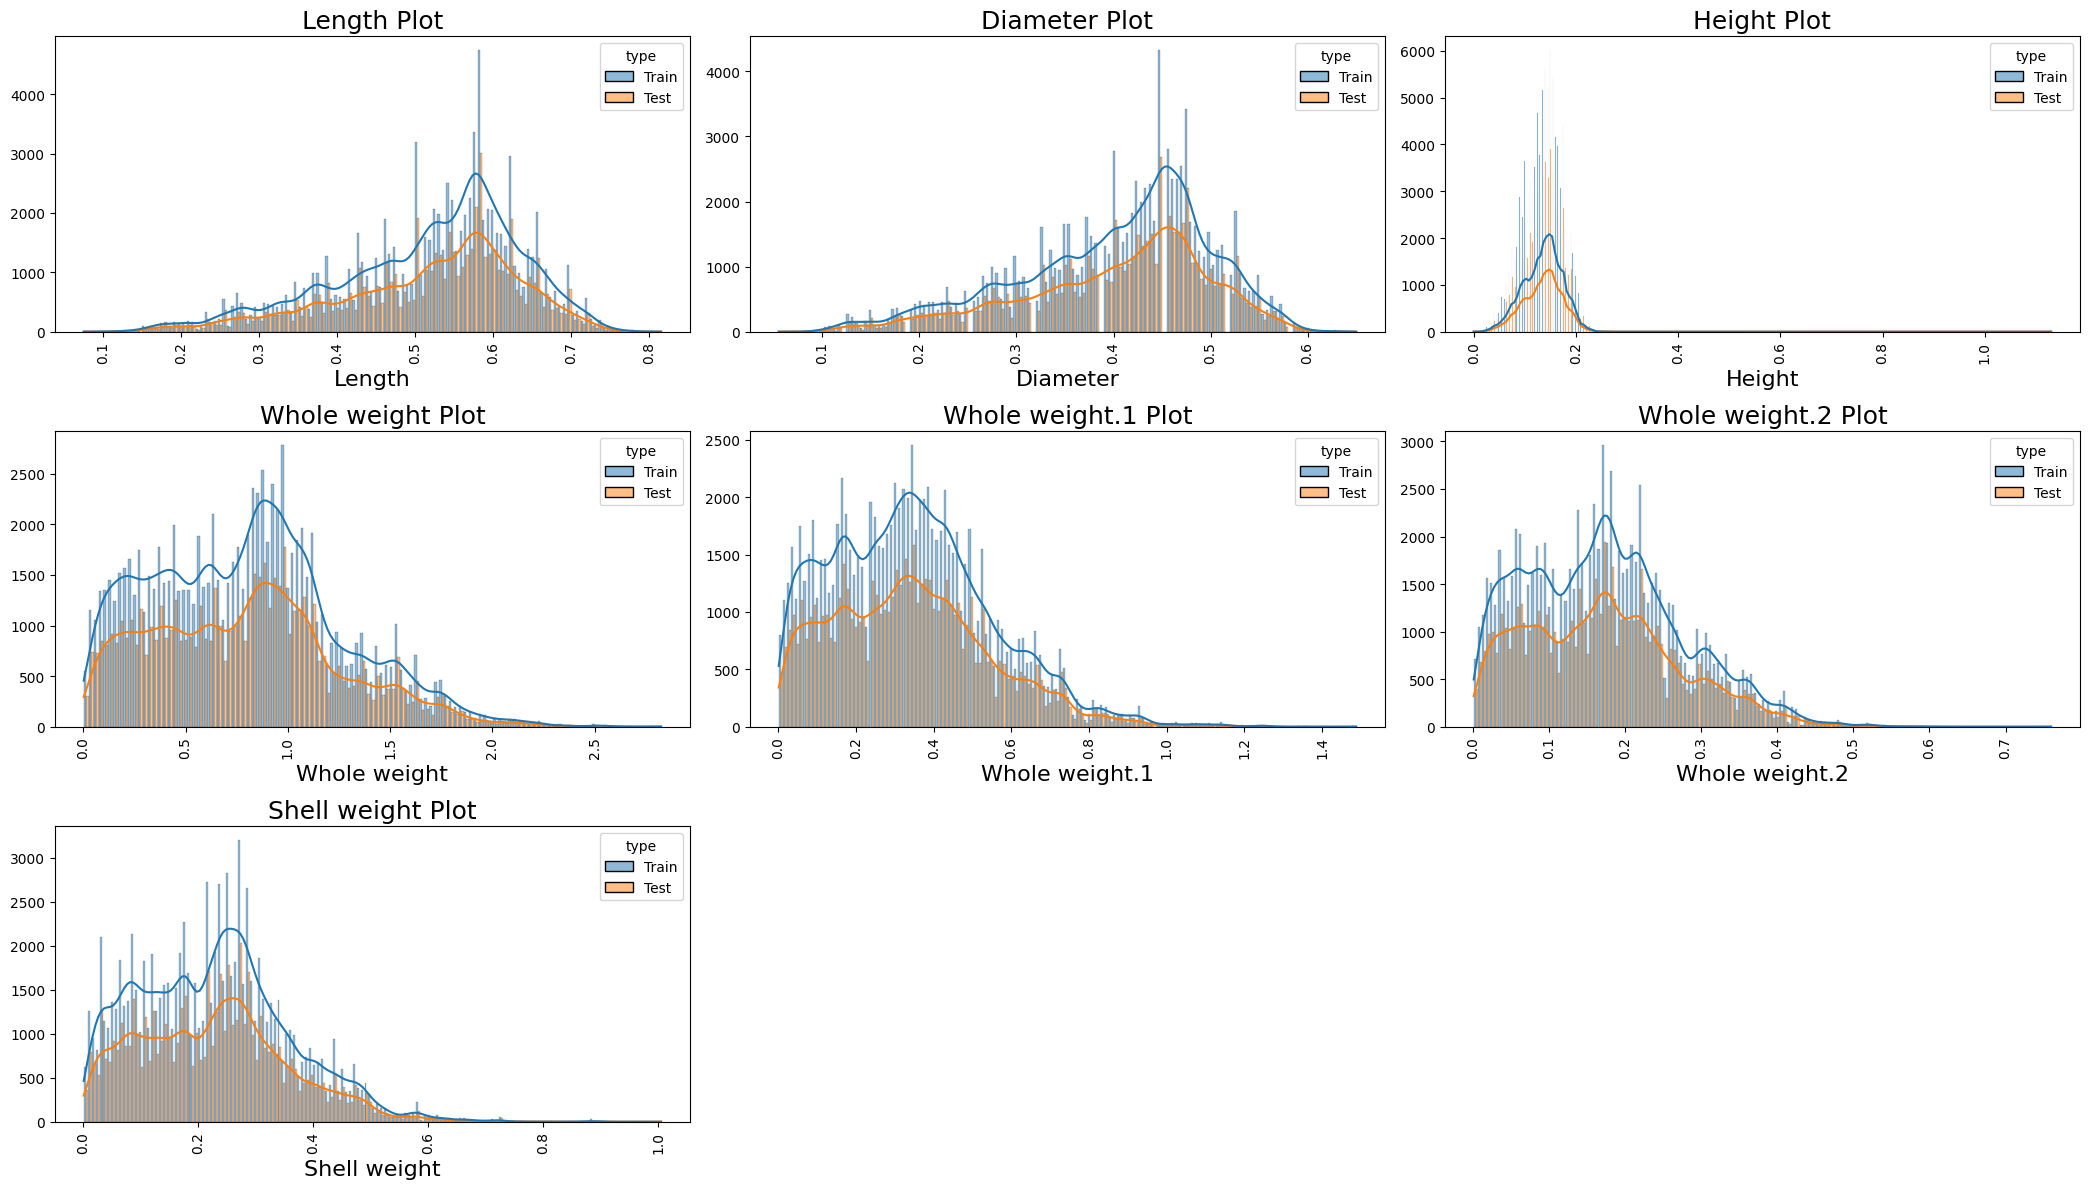

In [15]:
plot_histogram(df_train_final.drop(columns="Rings"), df_test,3)

Most of the variables are highly skewed. We might be able to make some features out of these. We can also try different transformations to see if we can reduce the skewness. There is not obvious data distribution between the test and the training data

Lets analyze the distribution of the target variable
Although target variable looks to be continuous (1) it has only 28 different values between 1- 29 (2) There is no value for 28. 

In [16]:
df_train_final["Rings"].unique()

array([15,  7,  9, 10,  8, 20, 16, 19, 14, 11, 12, 18, 13,  5,  4,  6, 21,
       17, 22,  1,  3, 26, 23, 29,  2, 27, 25, 24])

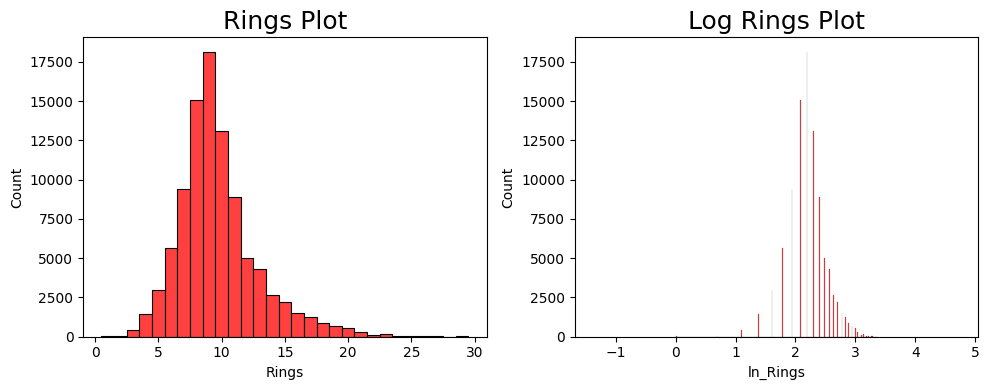

In [17]:
target_variable = df_train_final[["Rings"]]
target_variable["ln_Rings"] = np.log(target_variable[["Rings"]])

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.flatten()
sns.histplot(data=target_variable,x="Rings", ax=axs[0], color="red", discrete=True)        
axs[0].set_title(f'Rings Plot', fontsize=18)
sns.histplot(data=target_variable,x="ln_Rings", ax=axs[1], color="red")        
axs[1].set_title(f'Log Rings Plot', fontsize=18)
plt.margins(x=0.5)
plt.tight_layout()
plt.show()

Analyze the distribution of Sex Variable with respect to the target 

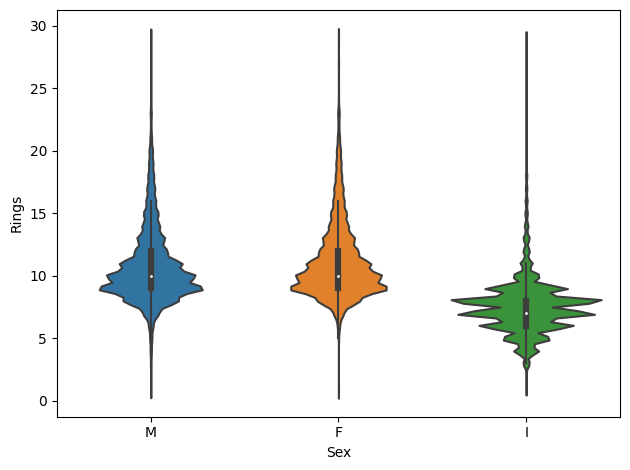

In [18]:
sns.violinplot(data=df_train_final, x="Sex", y="Rings")
plt.tight_layout()
plt.show()

The distribution of Male and Female is very similar. However, the distribution of the Infant looks very different

In [19]:
X=df_train_final.copy()
X=X.drop(columns="Rings")
y=df_train_final["Rings"]

df_log=[c for c in df_numerical if c != "Rings"]
df_log

['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight']

In [20]:
#Log Transformation
df_train_lg= df_train_final.copy(deep=True)
df_test_lg= df_test.copy(deep=True)

transformer = FunctionTransformer(np.log1p)
df_train_lg[df_log]= transformer.transform(df_train_lg[df_log])
df_test_lg[df_log]= transformer.transform(df_test_lg[df_log])

In [21]:
column_names=["Variable", "Original", "Log Transformation"]
basic_info_table = PrettyTable(column_names)
for c in df_train_final[df_numerical].columns:
    info_list=[]
    if (c != "Rings" ):
        info_list.append(c)
        info_list.append(np.round(df_train_final[c].skew(),3))
        info_list.append(np.round(df_train_lg[c].skew(),3))
        basic_info_table.add_row(info_list)
        
print(basic_info_table)    

+----------------+----------+--------------------+
|    Variable    | Original | Log Transformation |
+----------------+----------+--------------------+
|     Length     |  -0.727  |       -0.928       |
|    Diameter    |  -0.691  |       -0.859       |
|     Height     |  0.476   |       -0.055       |
|  Whole weight  |  0.436   |       -0.109       |
| Whole weight.1 |  0.601   |       0.221        |
| Whole weight.2 |  0.486   |       0.295        |
|  Shell weight  |  0.488   |       0.222        |
+----------------+----------+--------------------+


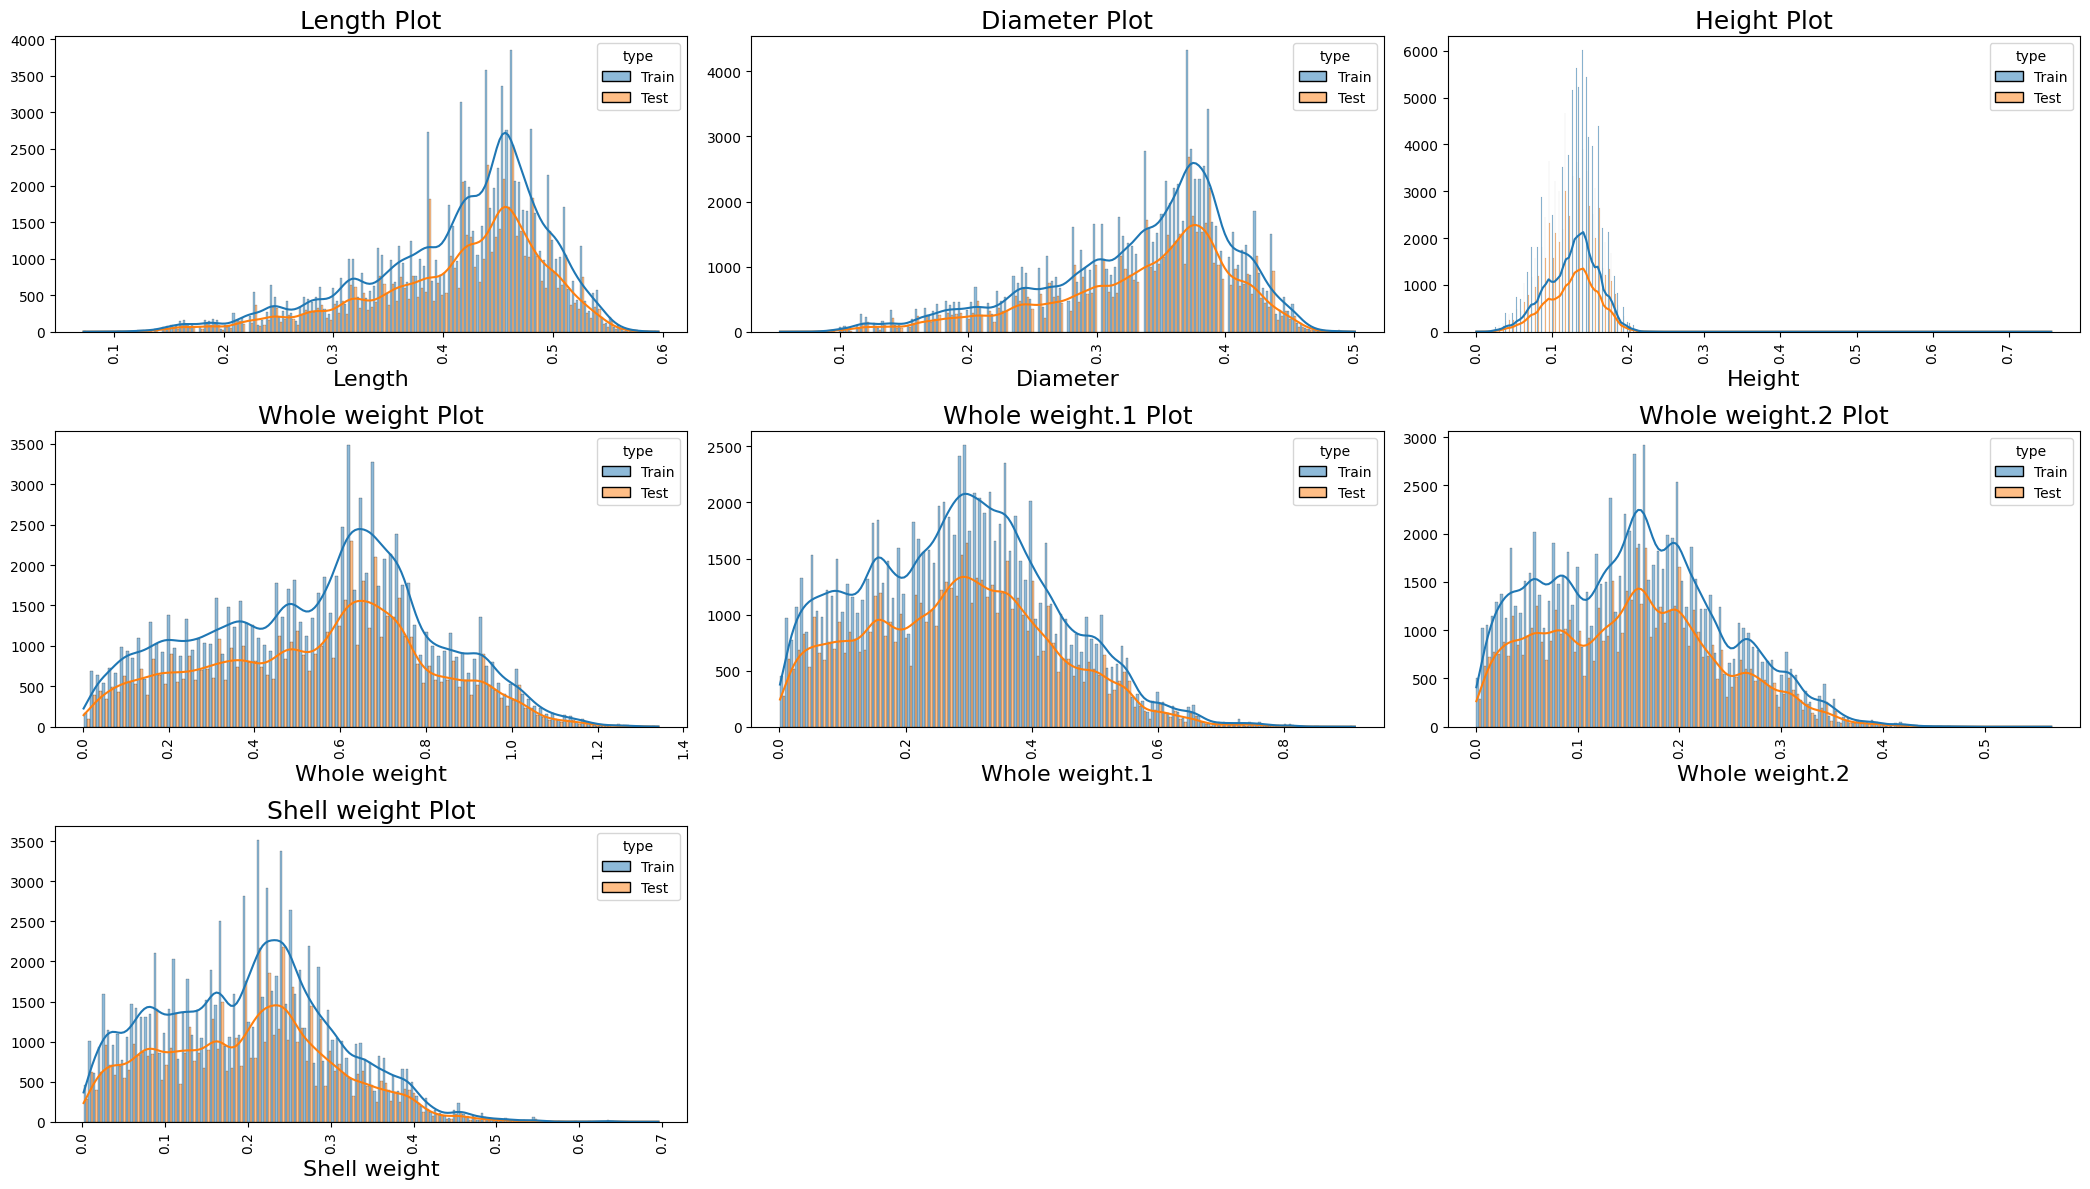

In [22]:
plot_histogram(df_train_lg.drop(columns="Rings"), df_test_lg,3)

Data is still skewed but there is less skewness

In [23]:
def plot_scatter_plot(train, n_cols):
    columns= train.drop(columns="Rings").columns.to_list()
    columns = [c for c in columns if c in df_numerical]
    n_rows = (len(columns) - 1) // n_cols + 1
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(21, 4 * n_rows))
    axs = axs.flatten()
    for i, column in enumerate(columns):
        sns.scatterplot(data=train,x=column, y="Rings", ax=axs[i], color="red")        
        axs[i].set_title(f'{column} Plot', fontsize=18)
        axs[i].set_xlabel(column, fontsize=16)
        axs[i].set_ylabel(None, fontsize=16)
        axs[i].tick_params(axis='x', rotation=90)
        
    #Remove any empty columns
    if ((len(columns)% n_cols) != 0):
        #There are some empty columns which we need to remove
        axs_len=len(axs)
        n_cols=len(columns)
        for i in range(n_cols,axs_len):
            axs[i].remove()
        
    plt.tight_layout()
    plt.show()

In [24]:
def plot_corr_matrix(df, var):
    corr_matrix = df[var].corr()
    print(corr_matrix)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.figure(figsize=(15, 12))
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
    plt.title('Correlation Matrix', fontsize=15)
    plt.show()

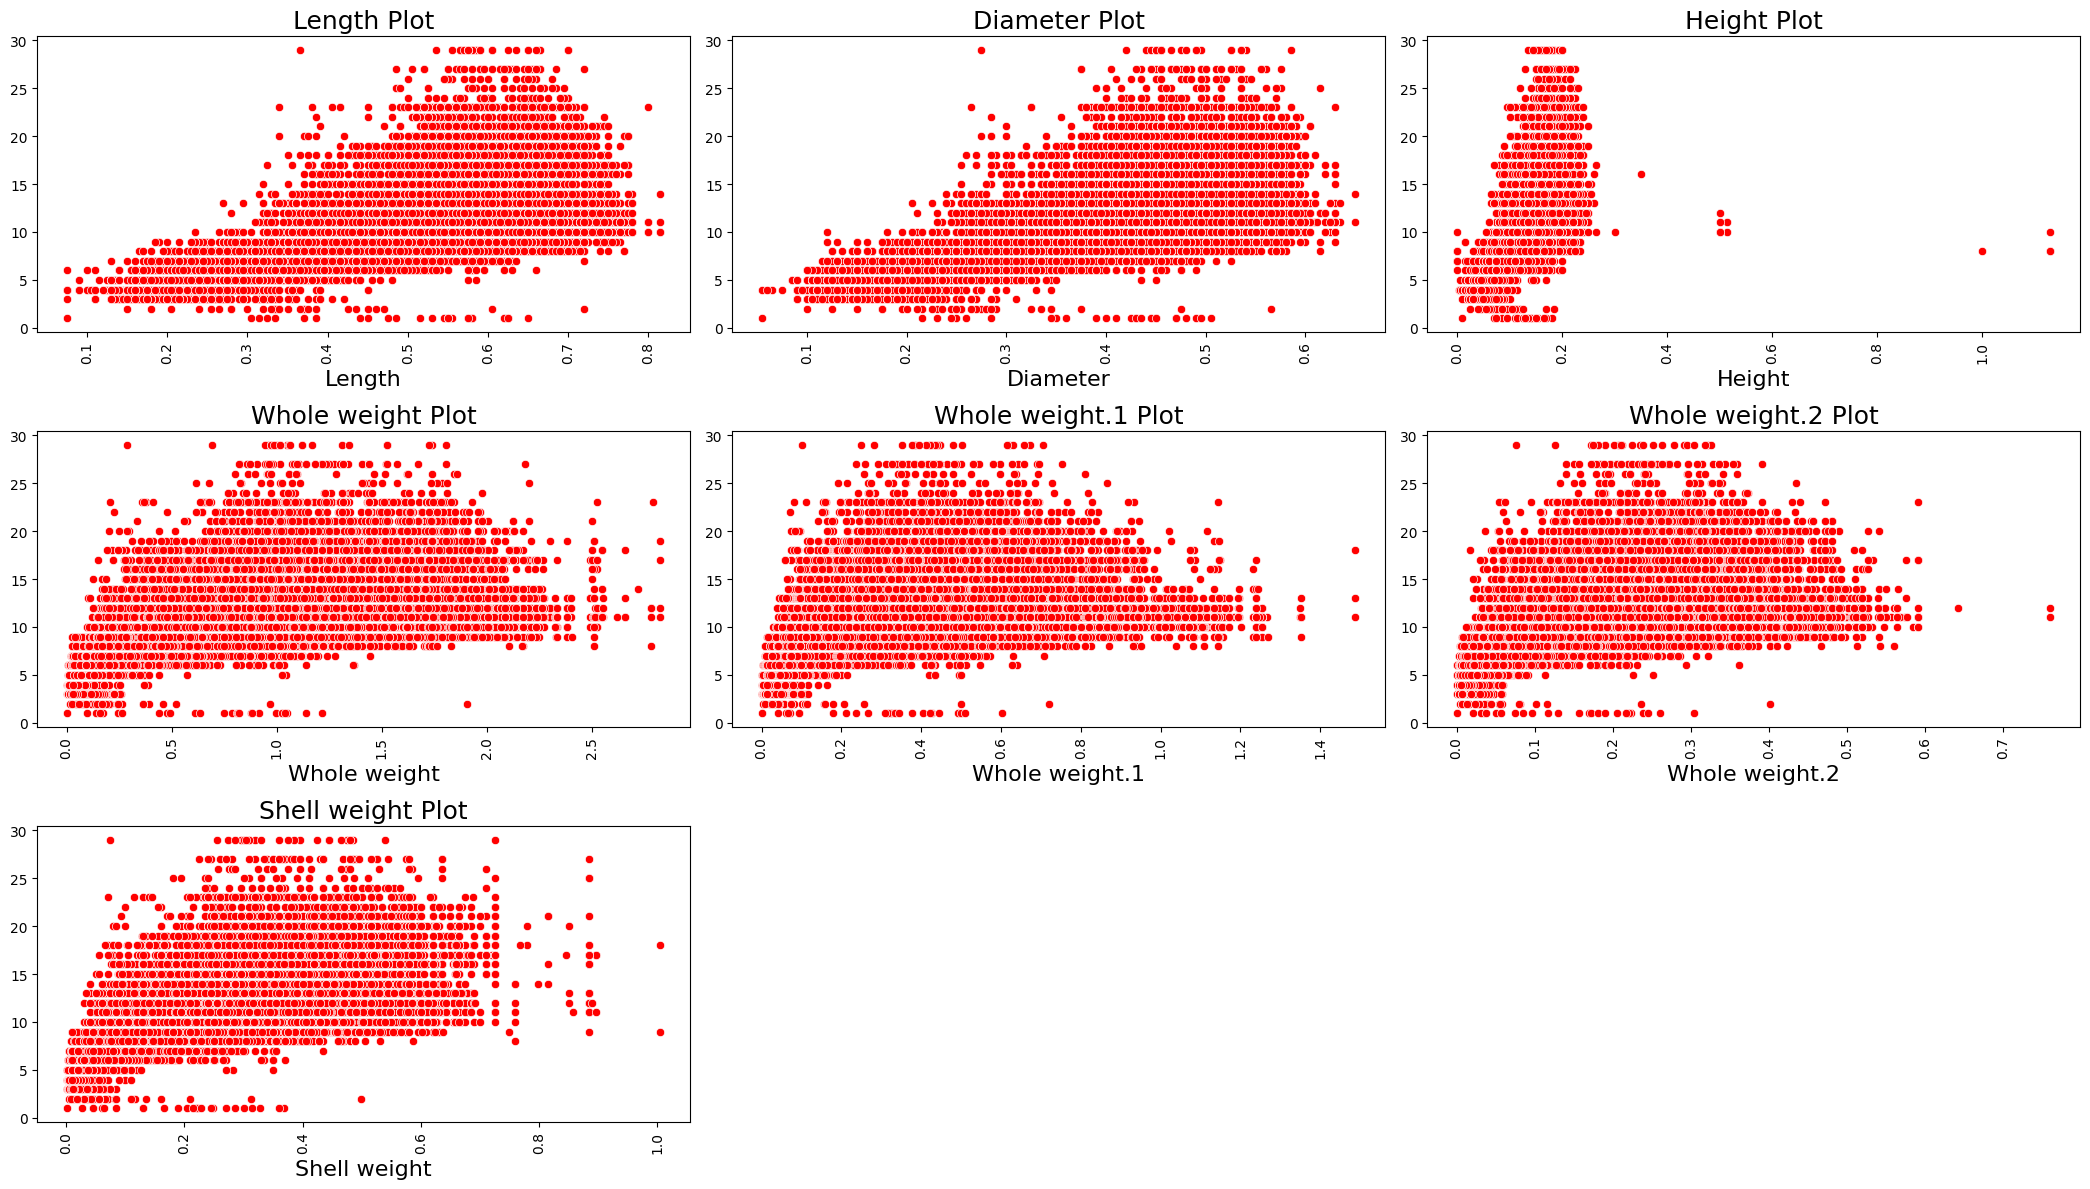

In [25]:
plot_scatter_plot(df_train_final,3)

                  Length  Diameter    Height  Whole weight  Whole weight.1  Whole weight.2  Shell weight     Rings
Length          1.000000  0.989732  0.916094      0.931449        0.909609        0.913134      0.911073  0.623786
Diameter        0.989732  1.000000  0.919618      0.933848        0.908466        0.914668      0.917871  0.636832
Height          0.916094  0.919618  1.000000      0.902344        0.861769        0.886132      0.904019  0.665772
Whole weight    0.931449  0.933848  0.902344      1.000000        0.971249        0.974319      0.964201  0.617274
Whole weight.1  0.909609  0.908466  0.861769      0.971249        1.000000        0.949227      0.911800  0.515067
Whole weight.2  0.913134  0.914668  0.886132      0.974319        0.949227        1.000000      0.937069  0.588954
Shell weight    0.911073  0.917871  0.904019      0.964201        0.911800        0.937069      1.000000  0.694766
Rings           0.623786  0.636832  0.665772      0.617274        0.515067      

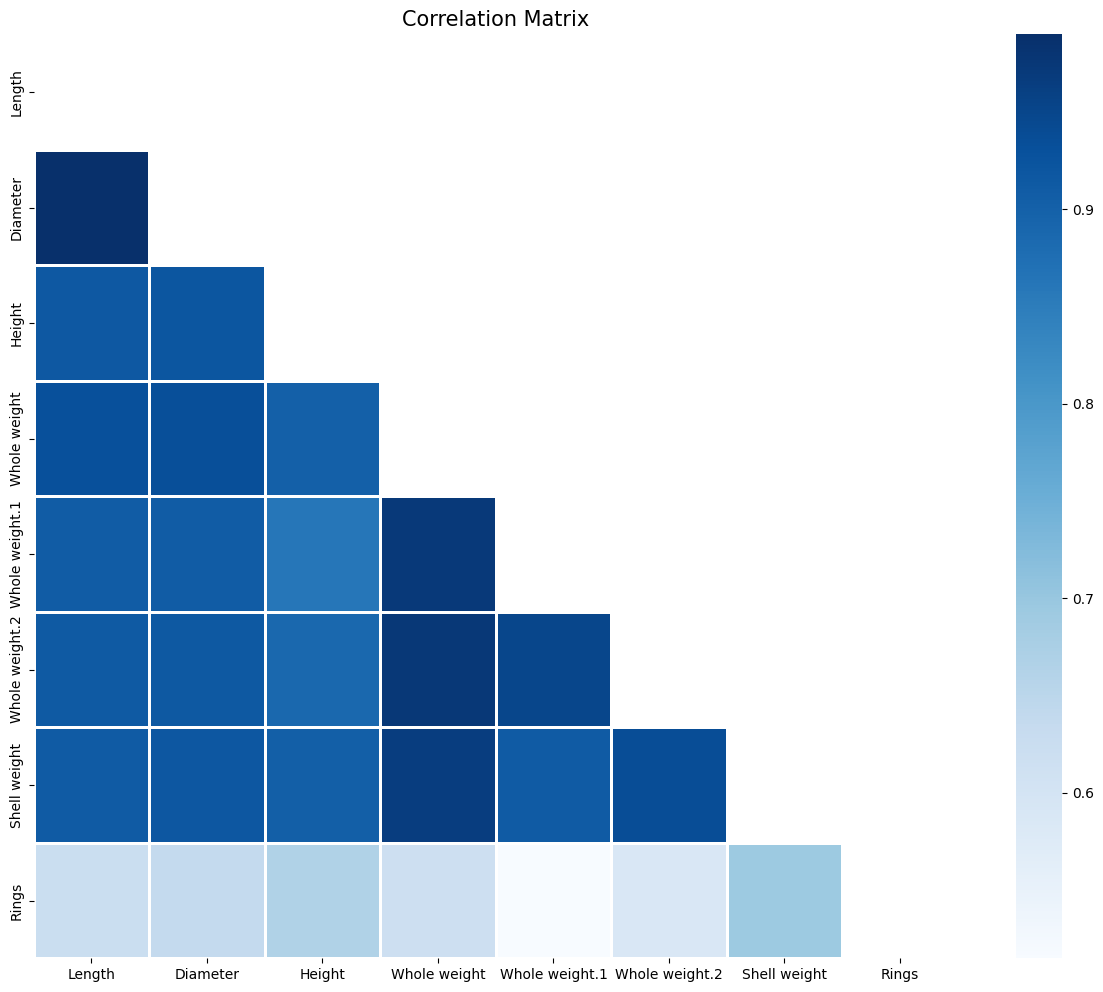

In [26]:
plot_corr_matrix(df_train, df_numerical)

All the variables are highly correlated with the Target variable : Rings. All the weight variables are also correlated with each other

In [27]:
id_sub=df_test["id"]
df_test=df_test.drop(columns=["id"])

In [28]:
df_numerical_model=X.select_dtypes(include=np.number).columns

# Data Pre-processing

In [29]:
log_processor=Pipeline(steps=[('log_transformation',FunctionTransformer(np.log1p))])
#log_processor=Pipeline(steps=[('log_transformation',PowerTransformer(method="yeo-johnson"))])
numerical_preprocessor=Pipeline(steps=[('scaler',StandardScaler())])
cat_preprocessor=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]) 
preprocessor=ColumnTransformer(transformers=[("log",log_processor,df_log),("scaler",numerical_preprocessor,df_numerical_model),("cat",cat_preprocessor,df_categorical)])

# Hyperparameter Tunning - LGBM

In [30]:
#LGBM
"""def objective(trial):
    params = {
         'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
         'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "boosting": trial.suggest_categorical('boosting', ['gbdt', 'dart']),
        "verbosity": -1,
        "random_state": 42,
        'objective': 'regression',
         'metric': 'rmse',
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)
    }
    skf=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    oofs_pred=[]
    for fold, (train_idx, test_idx) in enumerate(skf.split(X,y)):
        X_train, X_valid= X.iloc[train_idx],X.iloc[test_idx]
        y_train, y_valid= np.log1p(y[train_idx]), np.log1p(y[test_idx])
    
        #Build the model
        model = LGBMRegressor(**params)
        pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",model)])
        pipeline.fit(X_train, y_train)
        
        #Evaluate the model
        y_act_test= np.expm1(y_valid)
        y_pred_test=np.expm1(pipeline.predict(X_valid))
        y_pred_test= np.clip(y_pred_test, a_min = 1.0, a_max = 29)
        val_score= np.sqrt(mean_squared_log_error(y_act_test,y_pred_test))
               
        print(f"fold : {fold+1} MSLE: {val_score}")
        oofs_pred.append(val_score)
    score = np.mean(oofs_pred)    
    return score

study=optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
print(f"Best Study Parameters for LGBM: {study.best_params}")"""

'def objective(trial):\n    params = {\n         \'reg_alpha\': trial.suggest_float(\'reg_alpha\', 0, 1),\n         \'reg_lambda\': trial.suggest_float(\'reg_lambda\', 0, 1),\n        "num_leaves": trial.suggest_int("num_leaves", 2, 256),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 100, 1000, step=100),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01, 0.3),\n        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),\n        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),\n        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),\n        "boosting": trial.suggest_categorical(\'boosting\', [\'gbdt\', \'dart\']),\n        "verbosity": -1,\n        "random_state": 42,\n        \'objective\': \'regression\',\n         \'metric\': \'rmse\',\n        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)\n    }\n    skf=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)\n    oo

# Hyperparameter Tunning -CatBoost

In [31]:
#CatBoost
"""def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
         'depth': trial.suggest_int('depth', 3, 10),
         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
         'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
         'verbose': False,
         'eval_metric': 'MSLE',
         'loss_function': 'RMSE',
         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 1)
          }
    skf=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    oofs_pred=[]
    for fold, (train_idx, test_idx) in enumerate(skf.split(X,y)):
        X_train, X_valid= X.iloc[train_idx],X.iloc[test_idx]
        y_train, y_valid= np.log1p(y[train_idx]), np.log1p(y[test_idx])
    
        #Build the model
        model = CatBoostRegressor(**params)
        pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",model)])
        pipeline.fit(X_train, y_train)
        
        #Evaluate the model
        y_act_test= np.expm1(y_valid)
        y_pred_test=np.expm1(pipeline.predict(X_valid))
        y_pred_test= np.clip(y_pred_test, a_min = 1.0, a_max = 29)
        val_score= np.sqrt(mean_squared_log_error(y_act_test,y_pred_test))
               
        print(f"fold : {fold+1} MSLE: {val_score}")
        oofs_pred.append(val_score)
    score = np.mean(oofs_pred)    
    return score

study=optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
print(f"Best Study Parameters for CatBoost: {study.best_params}")"""

'def objective(trial):\n    params = {\n        \'iterations\': trial.suggest_int(\'iterations\', 100, 1000, step=10),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01, 0.3),\n         \'depth\': trial.suggest_int(\'depth\', 3, 10),\n         \'subsample\': trial.suggest_float(\'subsample\', 0.5, 1.0),\n         \'colsample_bylevel\': trial.suggest_float(\'colsample_bylevel\', 0.5, 1.0),\n         \'verbose\': False,\n         \'eval_metric\': \'MSLE\',\n         \'loss_function\': \'RMSE\',\n         \'l2_leaf_reg\': trial.suggest_float(\'l2_leaf_reg\', 0, 1)\n          }\n    skf=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)\n    oofs_pred=[]\n    for fold, (train_idx, test_idx) in enumerate(skf.split(X,y)):\n        X_train, X_valid= X.iloc[train_idx],X.iloc[test_idx]\n        y_train, y_valid= np.log1p(y[train_idx]), np.log1p(y[test_idx])\n    \n        #Build the model\n        model = CatBoostRegressor(**params)\n        pipeline=Pipeline(step

# Hyperparameter Tunning - XGBRegressor

In [32]:
"""def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 100),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000, step=10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbtree', 'dart']),
         'eval_metric': 'rmsle',
        'objective': 'reg:squaredlogerror'
          }
    skf=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    oofs_pred=[]
    for fold, (train_idx, test_idx) in enumerate(skf.split(X,y)):
        X_train, X_valid= X.iloc[train_idx],X.iloc[test_idx]
        y_train, y_valid= np.log1p(y[train_idx]), np.log1p(y[test_idx])
    
        #Build the model
        model = XGBRegressor(**params)
        pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",model)])
        pipeline.fit(X_train, y_train)
        
        #Evaluate the model
        y_act_test= np.expm1(y_valid)
        y_pred_test=np.expm1(pipeline.predict(X_valid))
        y_pred_test= np.clip(y_pred_test, a_min = 1.0, a_max = 29)
        val_score= np.sqrt(mean_squared_log_error(y_act_test,y_pred_test))
               
        print(f"fold : {fold+1} MSLE: {val_score}")
        oofs_pred.append(val_score)
    score = np.mean(oofs_pred)    
    return score

study=optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
print(f"Best Study Parameters for XGBoost: {study.best_params}")"""

'def objective(trial):\n    params = {\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 100),\n        \'num_leaves\': trial.suggest_int(\'num_leaves\', 20, 150),\n        \'reg_alpha\': trial.suggest_float(\'reg_alpha\', 0.0, 1.0),\n        \'reg_lambda\': trial.suggest_float(\'reg_lambda\', 0.0, 1.0),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01, 0.3),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 50, 2000, step=10),\n        \'subsample\': trial.suggest_float(\'subsample\', 0.5, 1.0),\n        \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.1, 1.0),\n        \'boosting_type\': trial.suggest_categorical(\'boosting_type\', [\'gbtree\', \'dart\']),\n         \'eval_metric\': \'rmsle\',\n        \'objective\': \'reg:squaredlogerror\'\n          }\n    skf=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)\n    oofs_pred=[]\n    for fold, (train_idx, test_idx) in enumerate(skf.split(X,y)):\n        X_train,

#  Ensemble Weight Tunning

In [33]:
"""def objective(trial):
    # Define search space for weights
    weight_xgb = trial.suggest_float('weight_xgb', 0.0, 1.0)
    weight_lgbm = trial.suggest_float('weight_lgbm', 0.0, 1.0 - weight_xgb)
    weight_catboost = 1.0 - weight_xgb - weight_lgbm
    
    skf=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    oofs_pred=[]
    for fold, (train_idx, test_idx) in enumerate(skf.split(X,y)):
        X_train, X_valid= X.iloc[train_idx],X.iloc[test_idx]
        y_train, y_valid= np.log1p(y[train_idx]), np.log1p(y[test_idx])
    
        #LGBM Model
        lgbm_params=  {'objective': 'regression',
                'metric': 'rmse',
                'verbosity': -1,
                'reg_alpha': 0.4262408809301502,
                'reg_lambda': 0.4985601420411856, 
                'num_leaves': 84, 'n_estimators': 800,
                'learning_rate': 0.022412922983504144,
                'feature_fraction': 0.4682219927339269, 
                'bagging_fraction': 0.9561646722909559, 
                'bagging_freq': 3,
                'boosting': 'gbdt', 
                'random_state': 42,  
                'min_child_samples': 72}

        lgbm_model = LGBMRegressor(**lgbm_params)
        lgb_pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",lgbm_model)])
        lgb_pipeline.fit(X_train, y_train)
        y_pred_test_lgbm=np.expm1(lgb_pipeline.predict(X_valid))
        y_pred_test_lgbm= np.clip(y_pred_test_lgbm, a_min = 1.0, a_max = 29)
        
        xgb_params=  {'n_estimators': 500,
            'max_depth': 6,
            'learning_rate': 0.0116,
            'colsample_bytree': 1,
            'min_child_weight': 9,
            'n_jobs': -1,
            'eval_metric': 'rmsle',
            'objective': "reg:squarederror",
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': 42}
        xgb_model = XGBRegressor(**xgb_params)
        xgb_pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",xgb_model)])
        xgb_pipeline.fit(X_train, y_train)
        y_pred_test_xgb=np.expm1(xgb_pipeline.predict(X_valid))
        y_pred_test_xgb= np.clip(y_pred_test_xgb, a_min = 1.0, a_max = 29)
        
        catb_params=  {'iterations': 1000, 
              'learning_rate': 0.10578337136111883, 
              'depth': 7, 'subsample': 0.9333437011786913, 
              'colsample_bylevel': 0.5293224143468107, 
              'l2_leaf_reg': 0.4534838505692489,
              'verbose': False,
              'eval_metric': 'MSLE',
              'loss_function': 'RMSE',
             'random_seed': 42}
    
        catb_model = CatBoostRegressor(**catb_params)
        catb_pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",catb_model)])
        catb_pipeline.fit(X_train, y_train)
        y_pred_test_catb=np.expm1(catb_pipeline.predict(X_valid))
        y_pred_test_catb= np.clip(y_pred_test_catb, a_min = 1.0, a_max = 29)

        # Weighted averaging
        ensemble_preds = (weight_xgb * y_pred_test_xgb + weight_lgbm * y_pred_test_lgbm + weight_catboost * y_pred_test_catb)

        # Evaluate the performance using cross-validation
        y_act_test= np.expm1(y_valid)
        val_score= np.sqrt(mean_squared_log_error(y_act_test,ensemble_preds))
               
        print(f"fold : {fold+1} MSLE: {val_score}")
        oofs_pred.append(val_score)
    score = np.mean(oofs_pred)    
    return score

study=optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
print(f"Best Weights  for Ensemble: {study.best_params}")    """

'def objective(trial):\n    # Define search space for weights\n    weight_xgb = trial.suggest_float(\'weight_xgb\', 0.0, 1.0)\n    weight_lgbm = trial.suggest_float(\'weight_lgbm\', 0.0, 1.0 - weight_xgb)\n    weight_catboost = 1.0 - weight_xgb - weight_lgbm\n    \n    skf=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)\n    oofs_pred=[]\n    for fold, (train_idx, test_idx) in enumerate(skf.split(X,y)):\n        X_train, X_valid= X.iloc[train_idx],X.iloc[test_idx]\n        y_train, y_valid= np.log1p(y[train_idx]), np.log1p(y[test_idx])\n    \n        #LGBM Model\n        lgbm_params=  {\'objective\': \'regression\',\n                \'metric\': \'rmse\',\n                \'verbosity\': -1,\n                \'reg_alpha\': 0.4262408809301502,\n                \'reg_lambda\': 0.4985601420411856, \n                \'num_leaves\': 84, \'n_estimators\': 800,\n                \'learning_rate\': 0.022412922983504144,\n                \'feature_fraction\': 0.4682219927339269, \n    

# Final model - Based on Ensemble Approach

In [34]:
weight_xgb = 0.02606424022376863
weight_lgbm = 0.7963794766690278
weight_catboost = 1.0 - weight_xgb - weight_lgbm
    
skf=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
oofs_pred=[]
sub_predictions=[]
for i, (train_idx, test_idx) in enumerate(skf.split(X,y)):
    X_train, X_valid= X.iloc[train_idx],X.iloc[test_idx]
    y_train, y_valid= np.log1p(y[train_idx]), np.log1p(y[test_idx])
    
    #LGBM Model
    lgbm_params=  {'objective': 'regression',
            'metric': 'rmse',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'random_state': 42,
            'num_leaves': 101,
            'learning_rate': 0.020164485897084788,
            'max_depth': 11,
            'min_child_samples': 44,
            'reg_alpha': 0.0015998545481907163,
            'reg_lambda': 2.1013623382075584e-05,
            'subsample': 0.9297914833388262,
            'colsample_bytree': 0.4482569076375125,
            'n_estimators': 1241}

    lgbm_model = LGBMRegressor(**lgbm_params)
    lgb_pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",lgbm_model)])
    lgb_pipeline.fit(X_train, y_train)
    y_pred_test_lgbm=np.expm1(lgb_pipeline.predict(X_valid))
    y_pred_test_lgbm= np.clip(y_pred_test_lgbm, a_min = 1.0, a_max = 29)
    y_sub_pred_lgbm=np.expm1(lgb_pipeline.predict(df_test))
        
    xgb_params=  {'n_estimators': 500,
            'max_depth': 6,
            'learning_rate': 0.0116,
            'colsample_bytree': 1,
            'min_child_weight': 9,
            'n_jobs': -1,
            'eval_metric': 'rmsle',
            'objective': "reg:squarederror",
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': 42}
    xgb_model = XGBRegressor(**xgb_params)
    xgb_pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",xgb_model)])
    xgb_pipeline.fit(X_train, y_train)
    y_pred_test_xgb=np.expm1(xgb_pipeline.predict(X_valid))
    y_pred_test_xgb= np.clip(y_pred_test_xgb, a_min = 1.0, a_max = 29)
    y_sub_pred_xgb=np.expm1(xgb_pipeline.predict(df_test))
    
    catb_params=  {'iterations': 1000, 
              'learning_rate': 0.10578337136111883, 
              'depth': 7, 'subsample': 0.9333437011786913, 
              'colsample_bylevel': 0.5293224143468107, 
              'l2_leaf_reg': 0.4534838505692489,
              'verbose': False,
              'eval_metric': 'MSLE',
              'loss_function': 'RMSE',
             'random_seed': 42}
    
    catb_model = CatBoostRegressor(**catb_params)
    catb_pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",catb_model)])
    catb_pipeline.fit(X_train, y_train)
    y_pred_test_catb=np.expm1(catb_pipeline.predict(X_valid))
    y_pred_test_catb= np.clip(y_pred_test_catb, a_min = 1.0, a_max = 29)
    y_sub_pred_catb=np.expm1(catb_pipeline.predict(df_test))
    
    # Weighted averaging
    ensemble_preds = (weight_xgb * y_pred_test_xgb + weight_lgbm * y_pred_test_lgbm + weight_catboost * y_pred_test_catb)
    ensemble_sub = (weight_xgb * y_sub_pred_xgb + weight_lgbm * y_sub_pred_lgbm + weight_catboost * y_sub_pred_catb)
    
    
    # Evaluate the performance using cross-validation
    y_act_test= np.expm1(y_valid)
    val_score= np.sqrt(mean_squared_log_error(y_act_test,ensemble_preds))
    
    
    sub_predictions.append(ensemble_sub)
    print(f"fold : {i+1} MSLE: {val_score}")
    oofs_pred.append(val_score)
print(f"MSLE of OOFS based on Ensemble: {np.mean(oofs_pred)}")    
#sub_pred_final=  sub_pred/skf.n_splits    
sub_pred_final= np.mean(sub_predictions, axis=0)

    

fold : 1 MSLE: 0.14810446142064956
fold : 2 MSLE: 0.14785637435952642
fold : 3 MSLE: 0.1499105373991065
fold : 4 MSLE: 0.14871477426283589
fold : 5 MSLE: 0.1465120589120888
fold : 6 MSLE: 0.14628184494178922
fold : 7 MSLE: 0.14917747219060376
fold : 8 MSLE: 0.1467281873277053
fold : 9 MSLE: 0.15067154391082327
fold : 10 MSLE: 0.14921226174532223
MSLE of OOFS based on Ensemble: 0.1483169516470451


# Final Submission

In [35]:
pred_df=pd.DataFrame(columns=["Rings"])
pred_df["Rings"]= sub_pred_final.tolist()
pred_df["id"] = id_sub.tolist()
pred_df.to_csv('submission.csv', index=False)
pred_df

,Rings,id
0,9.826582,90615
1,9.770521,90616
2,9.935565,90617
3,10.566147,90618
4,7.592047,90619
...,...,...
60406,6.312752,151021
60407,9.347373,151022
60408,12.396512,151023
60409,13.543768,151024
